In [1]:
import numpy as np
import pykitti
import os
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy
import sys
sys.path.append("/Users/lzherdeva/Docs/Open3D/build/lib")
import py3d

from tqdm import tqdm

In [3]:
basedir = '/Users/lzherdeva/Docs/Diploma/'

def load_data(date, drive, frame):
    dataset = pykitti.raw(basedir, date, drive)
    velo_dataset = list(dataset.velo)
    velo_data = velo_dataset[frame]
    
    print('\nDrive: ' + str(dataset.drive))

    return velo_data

In [54]:
date = '2011_09_26'
drive = '0005'
velo_data = load_data(date, drive, 11)[:, [0,1,2]]


Drive: 2011_09_26_drive_0005_sync


In [5]:
date = '2011_09_26'
drive = '0005'
velo_data = load_data(date, drive, 150)[:, [0,1,2]]


Drive: 2011_09_26_drive_0005_sync


In [4]:
date = '2011_09_30'
drive = '0001'
velo_data = load_data(date, drive, 0)[:, [0,1,2]]


Drive: 2011_09_30_drive_0001_sync


In [5]:
velo_data = velo_data[np.where((velo_data[:, 0] > -20) & (velo_data[:, 0] < 20) 
                               & (velo_data[:, 1] > -20) & (velo_data[:, 1] < 20) & (velo_data[:, 2] < 2)
                               & (velo_data[:, 2] > -3))]

### Show input frame

In [7]:
pcd1 = py3d.PointCloud()
pcd1.points = py3d.Vector3dVector(velo_data)
py3d.draw_geometries([pcd1])

In [8]:
source_down = py3d.voxel_down_sample(pcd1, 0.3) # create a uniformly downsampled point cloud from an input point cloud
points = np.asarray(source_down.points)
velo_data = points

### Divide points into segments

In [9]:
def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))

def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def comp_angle(v1, v2):
    sign = dotproduct(v1, v2)
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    if sign > 0:
        if v1[1] < 0:
            return 360 - np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))
        else:
            return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))
    else:
        if v1[1] < 0:
            return 360 - np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))
        else:
            return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))
            

In [10]:
ref_vector = [1, 0]
step = 0
scanlines = [[] for _ in range(360*2)]
for i in range(len(velo_data)):
    angle = comp_angle(velo_data[:, [0, 1]][i], ref_vector)
    index = 0
    for step in np.arange(0.5, 360+0.5, 0.5):
        if angle < step and angle >= step-0.5:
            try:
                scanlines[index].append(velo_data[i])
            except:
                print(index, step)
        index+=1

$$ \frac{x - x_1}{x_2 - x_1} = \frac{y - y_1}{y_2 - y_1} = \frac{z - z_1}{z_2 - z_1}$$


### Sorted by z-coordinate

In [11]:
import operator
from convert import convert_to_variables

In [12]:
scans = [[] for _ in range(len(scanlines))]
for num in range(0, len(scanlines), 1):
    zs = {}
    for i, p in enumerate(scanlines[num]):
        if p[1] == 0:
            z = p[1] / p[0]
        else:
            y = np.sqrt(1. / (1. + (p[0] / p[1]) ** 2))
            z = y * (p[2] / p[1])
        zs[z] = i
    sorted_zs  = np.array(sorted(zs.items(), key=operator.itemgetter(0)))
    if len(sorted_zs) == 0:
        scans[num] = []
    else:
        true_scanline = []
        for index in sorted_zs[:, [1]]:
            true_scanline.append(scanlines[num][int(index)])
        true_scanline = np.array(true_scanline)
        scans[num] = true_scanline

### Create clusters

In [13]:
def get_clusters(cur_scan):
    clusters = [[] for _ in range(len(cur_scan))]
    base_pho = cur_scan[0][0]**2 + cur_scan[0][1]**2 + cur_scan[0][2]**2
    clusters[0].append(cur_scan[0])
    ind = 0
    for i in range(1, len(cur_scan)):
        pho = cur_scan[i][0]**2 + cur_scan[i][1]**2 + cur_scan[i][2]**2
        if abs(base_pho - pho) >=2:
            ind += 1
            clusters[ind].append(np.array(cur_scan[i]))
            base_pho = pho
        else:
            clusters[ind].append(np.array(cur_scan[i])) 
    return clusters


In [14]:
clusters = [[] for _ in range(len(scans))]
for i in range(len(scans)):
    if len(scans[i]) == 0:
        clusters[i] = []
    else:
        clusters[i] = get_clusters(scans[i])
    

### Get median == new scanlines

In [15]:
def get_new_scanline(clusters):
    medians = []
    for i in range(len(clusters)):
        if clusters[i] != []:
            medians.append(np.median(clusters[i], axis=0))
    return medians

In [16]:
new_scanlines = [[] for _ in range(len(clusters))]
for i in range(len(clusters)):
    new_scanlines[i] = get_new_scanline(clusters[i])
    ans = get_new_scanline(clusters[i])


### Get variables

In [18]:
sVs = [[] for _ in range(len(new_scanlines))]
for i in range(len(new_scanlines)):
    if len(new_scanlines[i]) == 1:
        sVs[i] = [0]
    elif len(new_scanlines[i]) == 0:
        sVs[i] = [0]
    else:
        try:
            sVs[i] = convert_to_variables(np.array(new_scanlines[i]))
        except:
            print(len(new_scanlines[i]))

In [19]:
def plot(sVs):
    plt.plot(range(len(sVs)), sVs)
    plt.show()

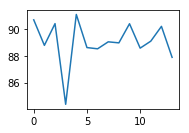

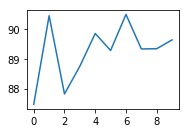

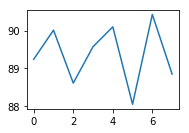

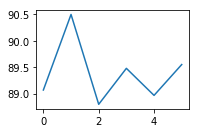

In [21]:
plt.figure(1)
for i in range(1, 5):
    plt.subplot(220+i)
    plot(sVs[i])
    

### CUSUM

In [22]:
from Statistics import Cusum

In [23]:
def calculate_cusum_for_scanline(sVs):
    stat_trajectory = []
    mean_0 = 0.
    mean_8 = 90.
    std = 1.

    cusum = Cusum(mean_0, mean_8, std, 20.) 
    for x_k in sVs:
        cusum.update(x_k)
        stat_trajectory.append(cusum._alarm)
    return stat_trajectory

In [24]:
trajectories_cusum = [[] for _ in range(len(sVs))]
for i in range(len(sVs)):
    if len(sVs[i]) == 1:
        trajectories_cusum[i] = 1
    else:
        trajectories_cusum[i] = calculate_cusum_for_scanline(sVs[i])

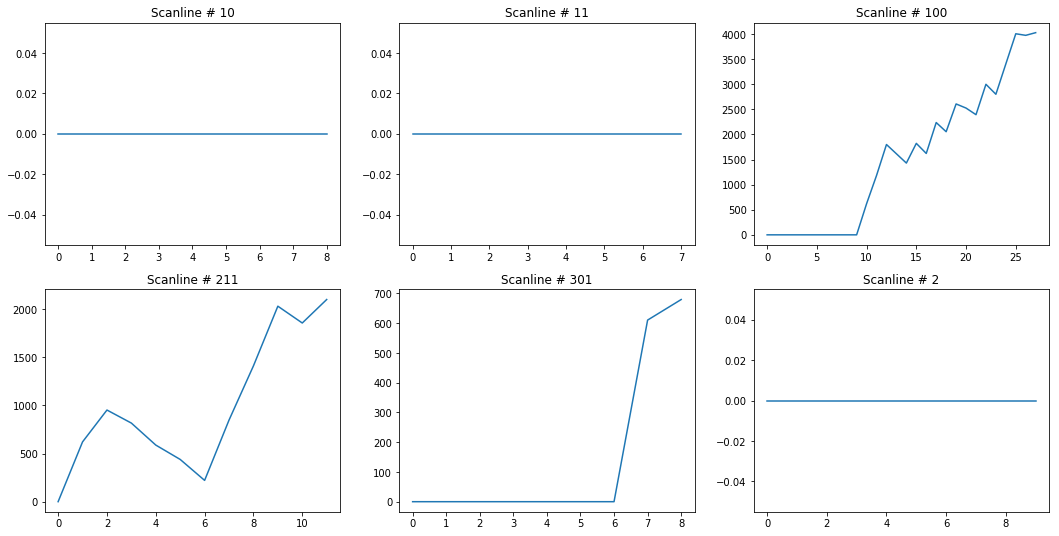

In [26]:
plt.figure(1, figsize=(18, 9))
plt.subplot(231)
plt.plot(trajectories_cusum[10])
plt.title('Scanline # 10')

plt.subplot(232)
plt.plot(trajectories_cusum[11])
plt.title('Scanline # 11')

plt.subplot(233)
plt.plot(trajectories_cusum[100])
plt.title('Scanline # 100')

plt.subplot(234)
plt.plot(trajectories_cusum[211])
plt.title('Scanline # 211')


plt.figure(1)
plt.subplot(235)
plt.plot(trajectories_cusum[301])
plt.title('Scanline # 301')

plt.subplot(236)
plt.plot(trajectories_cusum[2])
plt.title('Scanline # 2')


plt.show()


### Статистика Ширяева-Робертса

In [824]:
from Statistics import ShiryaevRoberts

In [825]:
def calculate_sr_for_scanline(sVs):
    stat_trajectory = []
    mean_0 = 90.
    mean_8 = 0.
    std = 1.


    sr = ShiryaevRoberts(mean_0, mean_8, 20., max_stat=1e6)
    for x_k in sVs:
        sr.update(x_k)
        stat_trajectory.append(sr._alarm)
    return stat_trajectory

In [826]:
trajectories_sr = [[] for _ in range(len(sVs))]
for i in range(len(sVs)):
    if len(sVs[i]) == 1:
        trajectories_sr[i] = 1
    else:
        trajectories_sr[i] = calculate_sr_for_scanline(sVs[i])

/Users/lzherdeva/Docs/Diploma/Statistics.py:67: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(mean_diff * (value - mean_diff / 2.))
/Users/lzherdeva/Docs/Diploma/Statistics.py:68: RuntimeWarning: overflow encountered in double_scalars
  self._stat = min(self._max_stat, (1. + self._stat) * likelihood)


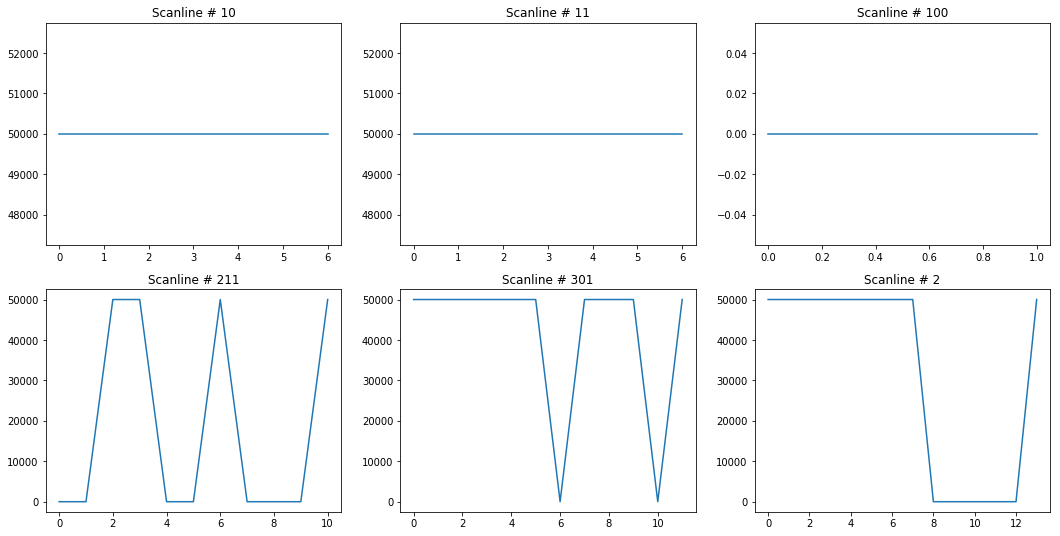

In [828]:
plt.figure(1, figsize=(18, 9))
plt.subplot(231)
plt.plot(trajectories_sr[10])
plt.title('Scanline # 10')

plt.subplot(232)
plt.plot(trajectories_sr[11])
plt.title('Scanline # 11')

plt.subplot(233)
plt.plot(trajectories_sr[100])
plt.title('Scanline # 100')

plt.subplot(234)
plt.plot(trajectories_sr[211])
plt.title('Scanline # 211')


plt.figure(1)
plt.subplot(235)
plt.plot(trajectories_sr[301])
plt.title('Scanline # 301')

plt.subplot(236)
plt.plot(trajectories_sr[2])
plt.title('Scanline # 2')


plt.show()



### Visualization

### CUSUM

In [27]:
changed_indx = [[] for _ in range(len(trajectories_cusum))]
zero_indx = [[] for _ in range(len(trajectories_cusum))]
for i in range(len(trajectories_cusum)):
    changed_indx[i] = np.nonzero(trajectories_cusum[i])[0]
    zero_indx[i] = np.where(np.asarray(trajectories_cusum[i]) == 0)[0]

In [28]:
changed_indx = np.array(changed_indx)
zero_indx = np.array(zero_indx)

In [29]:
horizontal = []
vertical = []
flag = False
for ind in range(len(new_scanlines)):
    flag = False
    if len(changed_indx[ind]) is not 0 and len(new_scanlines[ind]) is not 0:
        if len(new_scanlines[ind]) == 1 and changed_indx[ind] == 0:
            arr = np.array(new_scanlines[ind])[changed_indx[ind]]
        else:
            arr = np.array(new_scanlines[ind])[np.array(changed_indx[ind]+2)]
        vertical.append(arr)
        flag = True
    if len(zero_indx[ind]) is not 0:
        if len(new_scanlines[ind]) == 1 and zero_indx[ind] == 0:
            arr = np.array(new_scanlines[ind])[zero_indx[ind]]
        else:
            arr = np.array(new_scanlines[ind])[np.append([0, 1], np.array(zero_indx[ind]+2))]  
        horizontal.append(arr)
        flag = True
    if len(new_scanlines[ind]) != 1 and len(changed_indx[ind])!= 0 and len(new_scanlines[ind]) is not 0 and len(zero_indx[ind]) == 0:
        arr = np.array(new_scanlines[ind])[np.append([0, 1], np.array(zero_indx[ind]+2))]  
        horizontal.append(arr)
    if flag == False:
        horizontal.append(new_scanlines[ind])
        

In [31]:
ver_cloud = []
for i in range(len(vertical)):
    for p in vertical[i]:
        ver_cloud.append(p)
         
pcd1 = py3d.PointCloud()
pcd1.points = py3d.Vector3dVector(ver_cloud)

#py3d.draw_geometries([pcd1])

In [32]:
hor_cloud = []
for i in range(len(horizontal)):
    for p in horizontal[i]:
        hor_cloud.append(p)
        
        
pcd2 = py3d.PointCloud()
pcd2.points = py3d.Vector3dVector(hor_cloud)

#py3d.draw_geometries([pcd2])

In [33]:
def draw_registration_result(vertical, horizontal):
    vertical_temp = copy.deepcopy(vertical)
    horizontal_temp = copy.deepcopy(horizontal)
    vertical_temp.paint_uniform_color([1, 0, 0]) # red
    horizontal_temp.paint_uniform_color([0, 0, 1]) # blue
    py3d.draw_geometries([vertical_temp, horizontal_temp])

In [34]:
draw_registration_result(pcd1, pcd2)

### SR

In [830]:
changed_indx = [[] for _ in range(len(trajectories_sr))]
non_changed_indx = [[] for _ in range(len(trajectories_sr))]
for i in range(len(trajectories_sr)):
    non_changed_indx[i] = np.where(np.asarray(trajectories_sr[i]) == 50000.0)[0]
    changed_indx[i] = np.where(np.asarray(trajectories_sr[i]) != 50000.0)[0]

In [831]:
horizontal = []
vertical = []
flag = False
for ind in range(len(new_scanlines)):
    flag = False
    if len(changed_indx[ind]) is not 0 and len(new_scanlines[ind]) is not 0:
        if len(new_scanlines[ind]) == 1 and changed_indx[ind] == 0:
            arr = np.array(new_scanlines[ind])[changed_indx[ind]]
        else:
            arr = np.array(new_scanlines[ind])[np.array(changed_indx[ind]+2)]
        vertical.append(arr)
        flag = True
    if len(non_changed_indx[ind]) is not 0:
        if len(new_scanlines[ind]) == 1 and non_changed_indx[ind] == 0:
            arr = np.array(new_scanlines[ind])[non_changed_indx[ind]]
        else:
            arr = np.array(new_scanlines[ind])[np.append([0, 1], np.array(non_changed_indx[ind]+2))]  
        horizontal.append(arr)
        flag = True
    if len(new_scanlines[ind]) != 1 and len(changed_indx[ind])!= 0 and len(non_changed_indx[ind]) == 0 and len(new_scanlines[ind]) != 0:
        arr = np.array(new_scanlines[ind])[np.append([0, 1], np.array(non_changed_indx[ind]+2))]  
        horizontal.append(arr)
    if flag == False:
        horizontal.append(new_scanlines[ind])
        

In [832]:
ver_cloud = []
for i in range(len(vertical)):
    for p in vertical[i]:
        ver_cloud.append(p)
        
        
pcd1 = py3d.PointCloud()
pcd1.points = py3d.Vector3dVector(ver_cloud)

#py3d.draw_geometries([pcd1])

In [833]:
hor_cloud = []
for i in range(len(horizontal)):
    for p in horizontal[i]:
        hor_cloud.append(p)
        
        
pcd2 = py3d.PointCloud()
pcd2.points = py3d.Vector3dVector(hor_cloud)

#py3d.draw_geometries([pcd2])

In [835]:
draw_registration_result(pcd1, pcd2)

### Подсчет метрики CUSUM

In [503]:
my_data = []
for i in range(len(horizontal)):
    if len(horizontal[i]) is not 0:
        my_data.extend(np.hstack([horizontal[i], np.zeros((len(horizontal[i]), 1))]))
for i in range(len(vertical)):
    if len(vertical[i]) is not 0:
        my_data.extend(np.hstack([vertical[i], np.ones((len(vertical[i]), 1))]))
    

In [42]:
data_all = np.loadtxt('data_all.txt')
my_data = np.loadtxt('my_data.txt')

In [44]:
data_all = data_all[data_all[:, 2].argsort()]
data_all = data_all[data_all[:, 1].argsort(kind='mergesort')]
data_all = data_all[data_all[:, 0].argsort(kind='mergesort')]

In [45]:
my_data = my_data[my_data[:, 2].argsort()]
my_data = my_data[my_data[:, 1].argsort(kind='mergesort')]
my_data = my_data[my_data[:, 0].argsort(kind='mergesort')]

In [46]:
data = data_all[:, :3]
true_labels = data_all[:, 3]
data_my = my_data[:, :3]
my_labels = my_data[:, 3]

#### Соотношение точек

In [47]:
len(true_labels)/len(np.nonzero(true_labels)[0])

4.087490102929533

### Метрики

In [50]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [51]:
print(precision_score(true_labels, my_labels, average='weighted'))
print(precision_score(true_labels, my_labels, average=None))

0.7635822325577151
[0.8669081  0.44456463]


In [52]:
print(recall_score(true_labels, my_labels, average='weighted')) # Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
print(recall_score(true_labels, my_labels, average=None))

0.7156416464891041
[0.7366329  0.65083135]


In [819]:
print(f1_score(true_labels, my_labels, average='weighted'))
print(f1_score(true_labels, my_labels, average=None))

0.733550589708025
[0.76514503 0.68740837]


### Подсчет метрики SR

In [504]:
my_data_sr = []
for i in range(len(horizontal)):
    if len(horizontal[i]) is not 0:
        my_data_sr.extend(np.hstack([horizontal[i], np.zeros((len(horizontal[i]), 1))]))
for i in range(len(vertical)):
    if len(vertical[i]) is not 0:
        my_data_sr.extend(np.hstack([vertical[i], np.ones((len(vertical[i]), 1))]))

In [835]:
my_data_sr = np.loadtxt('my_data_sr.txt')

In [839]:
my_data_sr = my_data_sr[my_data_sr[:, 2].argsort()]
my_data_sr = my_data_sr[my_data_sr[:, 1].argsort(kind='mergesort')]
my_data_sr = my_data_sr[my_data_sr[:, 0].argsort(kind='mergesort')]

### Метрики

In [842]:
print(precision_score(true_labels, my_labels_sr, average='weighted'))
print(precision_score(true_labels, my_labels_sr, average=None))

0.7558594595259278
[0.73983265 0.77926587]


In [843]:
print(recall_score(true_labels, my_labels_sr, average='weighted'))
print(recall_score(true_labels, my_labels_sr, average=None))

0.7509433962264151
[0.89522016 0.54023384]


In [844]:
print(f1_score(true_labels, my_labels_sr, average='weighted'))
print(f1_score(true_labels, my_labels_sr, average=None))

0.740219221230729
[0.81014277 0.63809911]
